In [1]:
# Standard imports
import pandas as pd
import sys 
import os
import seaborn as sns
import os
import shutil
import numpy as np
import xtrack as xt
import matplotlib
import matplotlib.pyplot as plt
# Local imports
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# Apply better style
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=1, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='svg'

In [2]:
def get_amplitude_detuning(line, nemitt_x=1.e-6, nemitt_y=1.e-6, num_turns=100, zeropad=100000):
    '''
    returns axx, axy, ayx, ayy that correspond to the first order amplitude-detuning,
    estimated through tracking.
    The relations between tune (Q) and action (J) in this case is:
    $$ Q_x = Q_{x,0} + axx * Jx + axy * Jy $$
    $$ Q_y = Q_{y,0} + ayx * Jx + ayy * Jy $$
    '''

    egeom_x = nemitt_x / line.particle_ref.gamma0
    egeom_y = nemitt_y / line.particle_ref.gamma0

    frequency = np.fft.fftfreq(zeropad)

    sigma = 6
    num_r = 100
    JJ = np.linspace(0.01, sigma, num_r)
    A_norm = np.sqrt(2*JJ).flatten()
    other_norm = 0.01

    particles = line.build_particles(x_norm=A_norm, y_norm=other_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y =  line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axx = np.polyfit(JJ*egeom_x, qx, 1)[0]
    ayx = np.polyfit(JJ*egeom_x, qy, 1)[0]

    # switch x and y
    particles = line.build_particles(x_norm=other_norm, y_norm=A_norm,
                                     nemitt_x=nemitt_x, nemitt_y=nemitt_y)

    line.track(particles, num_turns=num_turns, turn_by_turn_monitor=True)
    # line.tracker._context.synchronize()

    x = line.record_last_track.x
    y = line.record_last_track.y

    qx = [abs(frequency[np.argmax(np.abs(np.fft.fft(x[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    qy = [abs(frequency[np.argmax(np.abs(np.fft.fft(y[ii]*np.hanning(x.shape[1]), n=zeropad)))]) for ii in range(x.shape[0])]
    # qx = NAFFlib.multiparticle_tunes(x)
    # qy = NAFFlib.multiparticle_tunes(y)

    axy = np.polyfit(JJ*egeom_y, qx, 1)[0]
    ayy = np.polyfit(JJ*egeom_y, qy, 1)[0]

    return axx, axy, ayx, ayy, JJ

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
axx = 4.284 um^-1
axy = 1.374 um^-1
ayx = 4.353 um^-1
ayy = 4.046 um^-1


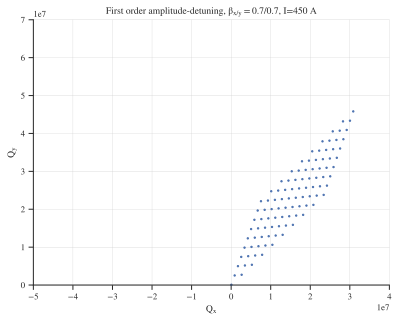

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
axx = 5.864 um^-1
axy = -8.296 um^-1
ayx = 6.203 um^-1
ayy = 5.849 um^-1


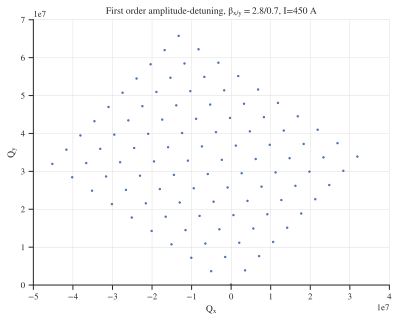

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_bb3d`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
axx = 5.800 um^-1
axy = 0.029 um^-1
ayx = 6.152 um^-1
ayy = 5.710 um^-1


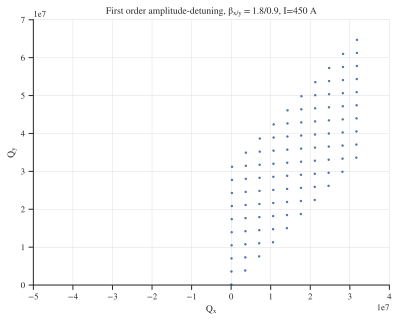

In [5]:
I = 450
for optics, (betax, betay) in zip(
    [
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_0/xtrack_0000/collider.json",
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_1/xtrack_0000/collider.json",
        "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/all_opt_collapse/collider_2/xtrack_0000/collider.json",
    ],
    [(0.7, 0.7), (0.7, 2.8), (0.9, 1.8)],
):
    collider = xt.Multiline.from_json(optics)
    collider.build_trackers()
    tw = collider.lhcb1.twiss()
    qx0 = tw.qx
    qy0 = tw.qy

    axx, axy, ayx, ayy, JJ = get_amplitude_detuning(collider.lhcb1)

    print(f"axx = {1.e-6*axx:.3f} um^-1")
    print(f"axy = {1.e-6*axy:.3f} um^-1")
    print(f"ayx = {1.e-6*ayx:.3f} um^-1")
    print(f"ayy = {1.e-6*ayy:.3f} um^-1")
    Jx, Jy = np.meshgrid(JJ[::10], JJ[::10])
    Q_x = qx0 + axx * Jx + axy * Jy
    Q_y = qy0 + ayx * Jx + ayy * Jy
    # Plot footprint
    plt.plot(Q_x, Q_y, ".", color="b", markersize=3)
    plt.plot([0.3, 0.32], [0.3, 0.32], "-")
    #plt.scatter([qx0], [qy0], marker="x", color="g", s=100, label="Working point")
    plt.title(
        "First order amplitude-detuning, " + r"$\beta_{x/y} =$" + f"{betay}/{betax}, " + f"I={I} A"
    )
    # plt.legend()
    plt.xlim(-5e7, 4e7)
    plt.ylim(0, 7e7)
    plt.xlabel(r"$Q_x$")
    plt.ylabel(r"$Q_y$")
    plt.grid()
    plt.savefig(f"footprint_{betay}_{betax}.png", dpi=300)
    plt.show()